<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468800 entries, 0 to 1468799
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   time        1468800 non-null  datetime64[ns]
 1   position_x  1468800 non-null  float64       
 2   position_y  1468800 non-null  float64       
 3   position_z  1468800 non-null  float64       
 4   velocity_x  1468800 non-null  float64       
 5   velocity_y  1468800 non-null  float64       
 6   velocity_z  1468800 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.4 MB

Position (m)


,position_x,position_y,position_z
count,1.468800e+06,1.468800e+06,1.468800e+06
mean,1.318576e+03,-3.649905e+03,-1.128563e+04
std,3.424989e+06,3.433794e+06,4.837916e+06
min,-6.852175e+06,-6.850168e+06,-6.850959e+06
1%,-6.632638e+06,-6.643278e+06,-6.846980e+06
5%,-5.815740e+06,-5.834224e+06,-6.766310e+06
50%,1.835549e+04,3.062016e+03,-1.385282e+04
95%,5.798344e+06,5.822577e+06,6.748106e+06
99%,6.632408e+06,6.640987e+06,6.828952e+06
max,6.852450e+06,6.850660e+06,6.833066e+06



Velocity (m/s)


,velocity_x,velocity_y,velocity_z
count,1.468800e+06,1.468800e+06,1.468800e+06
mean,-2.059675e-01,-2.800410e+00,-4.527040e+00
std,3.797389e+03,3.805891e+03,5.386418e+03
min,-7.600084e+03,-7.606932e+03,-7.621857e+03
1%,-7.358244e+03,-7.363741e+03,-7.617289e+03
5%,-6.446202e+03,-6.459445e+03,-7.527409e+03
50%,4.946644e+00,-6.141693e+00,-9.799852e+00
95%,6.438571e+03,6.463362e+03,7.526125e+03
99%,7.353963e+03,7.364802e+03,7.616713e+03
max,7.609148e+03,7.606214e+03,7.620832e+03


Time span: 2024-04-25 00:00:18 → 2024-05-15 00:00:17
Rows after 3σ position filter: 1468800
Unique epochs: 1468800
➡️ Saved GPS_clean.parquet with 1468800 rows


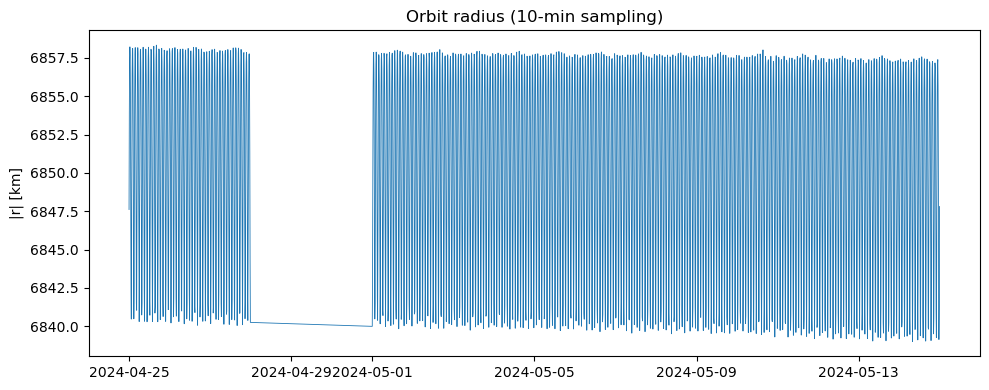

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 0. LOAD + RESHAPE  (handles long-format file)
# --------------------------------------------------
RAW_PATH = "GPS_measurements.parquet"
gps_long = pd.read_parquet(RAW_PATH)

# rename datetime → time for consistency
gps_long = gps_long.rename(columns={"datetime": "time"})

# pivot to wide: separate columns for each axis
gps_wide = (
    gps_long
    .pivot_table(index="time", columns="ECEF", values=["position", "velocity"])
    .reset_index()
)
gps_wide.columns = [
    "time",
    "position_x", "position_y", "position_z",
    "velocity_x", "velocity_y", "velocity_z",
]
gps_wide.info(show_counts=True)
gps_wide.head()

# --------------------------------------------------
# 1. COPY + UNIT CONVERSIONS
# --------------------------------------------------
df = gps_wide.copy()

# time already Timestamp; round to whole seconds
df["time"] = pd.to_datetime(df["time"]).dt.floor("s")

# scale positions km→m (×1000) and velocities dm/s→m/s (÷10)
pos_cols = [c for c in df.columns if c.startswith("position_")]
vel_cols = [c for c in df.columns if c.startswith("velocity_")]

df[pos_cols] *= 1_000        # km → m
df[vel_cols]  /= 10          # dm/s → m/s

# --------------------------------------------------
# 2. BASIC STATS  (same as template)
# --------------------------------------------------
def stat_block(cols, name):
    print(f"\n{name}")
    display(df[cols].describe(percentiles=[.01,.05,.5,.95,.99]))

stat_block(pos_cols, "Position (m)")
stat_block(vel_cols, "Velocity (m/s)")
print("Time span:", df["time"].min(), "→", df["time"].max())

# --------------------------------------------------
# 3. OUTLIER FILTER (same as template)
# --------------------------------------------------
df["r_norm_km"]  = np.linalg.norm(df[pos_cols].values, axis=1) / 1_000
df["v_norm_kms"] = np.linalg.norm(df[vel_cols].values, axis=1) / 1_000

mask = (np.abs((df["r_norm_km"] - df["r_norm_km"].mean()) / df["r_norm_km"].std()) <= 3)
df_clean = df[mask].reset_index(drop=True)
print("Rows after 3σ position filter:", len(df_clean))

# --------------------------------------------------
# 4. GROUP BY EPOCH
# --------------------------------------------------
grouped = df_clean.groupby("time", sort=True)
epochs  = list(grouped.groups)          # ordered list of epoch timestamps
print("Unique epochs:", len(epochs))

# --------------------------------------------------
# 5. SAVE CLEAN PARQUET
# --------------------------------------------------
CLEAN_PATH = "GPS_clean.parquet"
df_clean.to_parquet(CLEAN_PATH, index=False)
print("➡️ Saved", CLEAN_PATH, "with", len(df_clean), "rows")

# --------------------------------------------------
# 6. QUICK PLOT (optional)
# --------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(df_clean["time"][::600], df_clean["r_norm_km"][::600], lw=0.6)  # plot every 10 min
plt.ylabel("|r| [km]"); plt.title("Orbit radius (10-min sampling)"); plt.tight_layout()
